### Data Loading and Preprocessing

- **Objective**: Load and preprocess image data for classification.
- **Steps**:
  1. **Image Loading Function**:
     - The `load_images_from_folder()` function iterates through a specified dataset directory.
     - It assumes that each class of images is stored in its own subfolder.
     - Images are resized to a target size of 64x64 pixels and flattened into a 1D array.
     - Corresponding labels are extracted from subfolder names.
  2. **Dataset Path**:
     - The dataset folder is specified with the path `R:\UNIPROGRAM\data\data\Processed Leaf Images`.
  3. **Label Encoding**:
     - Class labels are encoded into numeric values using `LabelEncoder` from scikit-learn.
  4. **Train-Test Split**:
     - The dataset is split into training (80%) and testing (20%) subsets.
     - Stratified splitting ensures class distribution is preserved in both subsets.


In [3]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

def load_images_from_folder(folder, size=(64, 64)):
    """
    Load images from a directory. Assumes each class has its own subfolder.
    :param folder: Main dataset directory
    :param size: Tuple indicating target image size (e.g., (64, 64))
    :return: Flattened images and corresponding labels
    """
    images = []
    labels = []
    for label_folder in os.listdir(folder):
        label_path = os.path.join(folder, label_folder)
        if not os.path.isdir(label_path):
            continue
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = Image.open(img_path) #.convert('L')  # Convert to grayscale
            img = img.resize(size)
            images.append(np.array(img).flatten())  # Flatten the image
            labels.append(label_folder)
    return np.array(images), np.array(labels)

# Specify dataset folder and load data
dataset_folder = r"D:\UNIPROGRAM\data\data\Processed Leaf Images"
X, y = load_images_from_folder(dataset_folder)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train-Test Split Verification:")
print(f"Training samples: {len(y_train)}, Testing samples: {len(y_test)}")

Train-Test Split Verification:
Training samples: 46839, Testing samples: 11710


### Feature Scaling and Cross-Validation for k-NN

- **Objective**: Scale the features to normalize pixel intensity values and evaluate the k-NN model using cross-validation.

- **Steps**:
  1. **Feature Scaling**:
     - The `StandardScaler` is applied to normalize the feature values.
     - The training data (`X_train`) is fitted and transformed, and the test data (`X_test`) is transformed using the same scaler.
  2. **Initialize k-NN Classifier**:
     - A k-NN classifier is initialized with default parameters.
  3. **Cross-Validation**:
     - The `cross_val_score` function is used to perform 5-fold cross-validation on the scaled training data.
     - Cross-validation evaluates the model’s accuracy on different subsets of the training data, providing a more robust assessment.
  4. **Output Results**:
     - Cross-validation accuracy scores are printed for each fold.
     - The mean accuracy and the standard deviation of accuracy across folds are computed and displayed.

- **Output**:
  - Cross-validation accuracy scores for each fold.
  - Mean cross-validation accuracy.
  - Standard deviation of accuracy across folds.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up augmentation options
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)




In [6]:
import h5py
import numpy as np

# Parameters
chunk_size = 1000  # Process images in smaller chunks
augmentation_factor = 2  # Reduce augmentation factor
hdf5_file_path = 'augmented_data.h5'

# Open an HDF5 file to store augmented data
with h5py.File(hdf5_file_path, 'w') as f:
    # Create datasets for images and labels with expandable dimensions
    X_dataset = f.create_dataset('X_train', shape=(0, 64, 64, 3), maxshape=(None, 64, 64, 3), dtype='float32', chunks=True)
    y_dataset = f.create_dataset('y_train', shape=(0,), maxshape=(None,), dtype='int32', chunks=True)

    # Process original data in chunks
    for start in range(0, len(X_train), chunk_size):
        end = min(start + chunk_size, len(X_train))
        
        for i in range(start, end):
            # Prepare original image and label
            image = X_train[i].reshape(64, 64, -1)  # Dynamic channel handling
            label = y_train[i]
            
            # Generate augmented images
            augmented_images = datagen.flow(
                np.expand_dims(image, axis=0),  # Expand to 4D array
                batch_size=1
            )
            
            # Generate 'augmentation_factor' augmented images for each original image
            for _ in range(augmentation_factor):
                aug_image = augmented_images.__next__()[0]  # Get the augmented image
                X_dataset.resize((X_dataset.shape[0] + 1), axis=0)
                X_dataset[-1] = aug_image  # Save augmented image
                y_dataset.resize((y_dataset.shape[0] + 1), axis=0)
                y_dataset[-1] = label  # Save corresponding label

# Verify saved data
with h5py.File(hdf5_file_path, 'r') as f:
    print(f"Augmented Data Shape: {f['X_train'].shape}, Labels Shape: {f['y_train'].shape}")


Augmented Data Shape: (93678, 64, 64, 3), Labels Shape: (93678,)


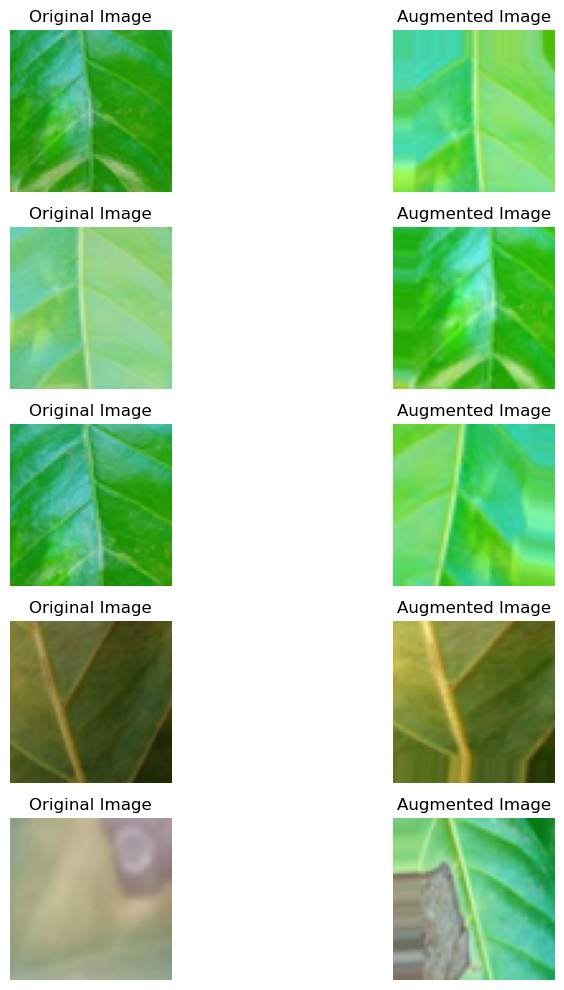

In [7]:
import matplotlib.pyplot as plt
import random

# Function to normalize images
def normalize_image(image):
    """
    Normalize image values for display.
    If the values are floats, scale them to [0, 1].
    If the values are integers, ensure they are in [0, 255].
    """
    if image.dtype == 'float32' or image.dtype == 'float64':
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    return image

# Function to display original and augmented images
def display_augmented_images_hdf5(original_images, hdf5_file_path, num_images=5):
    """
    Display a random selection of original and augmented images from the HDF5 file.
    :param original_images: Array of original images
    :param hdf5_file_path: Path to the HDF5 file containing augmented images
    :param num_images: Number of images to display
    """
    with h5py.File(hdf5_file_path, 'r') as f:
        augmented_images = f['X_train'][:]
        augmented_labels = f['y_train'][:]
    
        plt.figure(figsize=(10, num_images * 2))
        for i in range(num_images):
            # Random index for original images
            idx_original = random.randint(0, len(original_images) - 1)

            # Display original image
            plt.subplot(num_images, 2, i * 2 + 1)
            original_image = original_images[idx_original].reshape(64, 64, -1)
            normalized_original_image = normalize_image(original_image)  # Normalize image for display
            plt.imshow(normalized_original_image.squeeze(), cmap='gray' if normalized_original_image.shape[-1] == 1 else None)
            plt.title("Original Image")
            plt.axis('off')

            # Random index for augmented images
            idx_augmented = random.randint(0, len(augmented_images) - 1)

            # Display augmented image
            plt.subplot(num_images, 2, i * 2 + 2)
            augmented_image = augmented_images[idx_augmented].reshape(64, 64, -1)
            normalized_augmented_image = normalize_image(augmented_image)  # Normalize image for display
            plt.imshow(normalized_augmented_image.squeeze(), cmap='gray' if normalized_augmented_image.shape[-1] == 1 else None)
            plt.title("Augmented Image")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Display a random selection of original and augmented images
display_augmented_images_hdf5(X_train, 'augmented_data.h5', num_images=5)


In [8]:
import h5py
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Load augmented data from the HDF5 file
hdf5_file_path = 'augmented_data.h5'

with h5py.File(hdf5_file_path, 'r') as f:
    X_augmented = f['X_train'][:]
    y_augmented = f['y_train'][:]

# Match the shapes of original and augmented datasets
if X_train.ndim == 2:  # If original data is flattened
    X_augmented_flat = X_augmented.reshape(X_augmented.shape[0], -1)  # Flatten augmented data
    X_train_combined = np.concatenate((X_train, X_augmented_flat), axis=0)
else:  # If original data is not flattened
    X_train_reshaped = X_train.reshape(X_train.shape[0], 64, 64, 3)  # Adjust dimensions as needed
    X_train_combined = np.concatenate((X_train_reshaped, X_augmented), axis=0)

# Combine labels
y_train_combined = np.concatenate((y_train, y_augmented), axis=0)

# Normalize features (pixel intensity values)
scaler = StandardScaler()

# Flatten images for scaling (if not already flattened)
X_train_combined_flat = X_train_combined.reshape(X_train_combined.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train_combined_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Train and evaluate KNN model using cross-validation
knn = KNeighborsClassifier(n_neighbors=5)  # Set number of neighbors
cv_scores = cross_val_score(knn, X_train_scaled, y_train_combined, cv=5)

# Output cross-validation results
print("\nCross-Validation Results:")
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%")
print(f"Standard Deviation of Accuracy: {np.std(cv_scores) * 100:.2f}%")



Cross-Validation Results:
Cross-Validation Accuracy Scores: [0.99957301 0.9886493  0.95456001 0.95335018 0.95555635]
Mean Cross-Validation Accuracy: 97.03%
Standard Deviation of Accuracy: 1.97%


****************

In [ ]:
# Normalize features (pixel intensity values)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn = KNeighborsClassifier()
cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)

# Output cross-validation results
print("\nCross-Validation Results:")
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%")
print(f"Standard Deviation of Accuracy: {np.std(cv_scores) * 100:.2f}%")







### Hyperparameter Tuning and Evaluation of k-NN Using Grid Search

- **Objective**: Optimize the `n_neighbors` hyperparameter for the k-NN model using grid search, evaluate the model's performance, and visualize the results.

- **Steps**:
  1. **Define Parameter Grid**:
     - A range of possible values for `n_neighbors` is defined: `[1, 3, 5, 7, 9, 11]`.
  2. **Grid Search**:
     - `GridSearchCV` is used to perform a 3-fold cross-validation for each value of `n_neighbors` in the grid.
     - The evaluation metric is accuracy (`scoring='accuracy'`).
     - Verbose output is enabled for detailed progress monitoring.
  3. **Retrieve Best Parameters**:
     - After the grid search, the optimal value of `n_neighbors` is displayed along with the best cross-validation accuracy score.
  4. **Evaluate Best Model**:
     - The best-performing k-NN model (`best_knn`) is used to make predictions on the test set.
     - Test set accuracy is calculated and displayed.
  5. **Optional: Classification Report**:
     - A detailed classification report is printed for the best model's predictions on the test set.
  6. **Optional: Visualize Results**:
     - A plot of the cross-validation accuracy scores for each value of `n_neighbors` is generated to visualize how the model's performance varies with the hyperparameter.

- **Output**:
  - Optimal value of `n_neighbors`.
  - Best cross-validation accuracy.
  - Test set accuracy of the best model.
  - Optional: Classification report and plot of cross-validation accuracy.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................................n_neighbors=1; total time= 4.1min
[CV] END ......................................n_neighbors=1; total time= 4.2min
[CV] END ......................................n_neighbors=1; total time= 4.2min
[CV] END ......................................n_neighbors=1; total time= 7.6min
[CV] END ......................................n_neighbors=1; total time= 8.4min
[CV] END ......................................n_neighbors=3; total time= 7.8min
[CV] END ......................................n_neighbors=3; total time= 4.8min
[CV] END ......................................n_neighbors=3; total time= 4.4min
[CV] END ......................................n_neighbors=3; total time= 4.2min
[CV] END ......................................n_neighbors=3; total time= 4.1min
[CV] END ......................................n_neighbors=5; total time= 4.1min
[CV] END ......................................n_

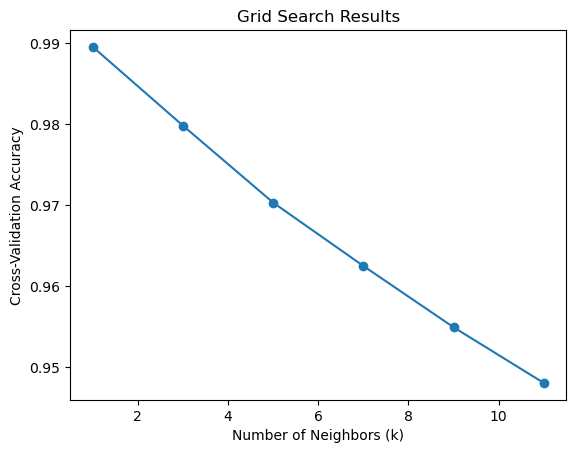

In [9]:
# Define parameter grid
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11]}

# Grid search for k-NN
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=2)

# Use y_train_combined instead of y_train
grid_search.fit(X_train_scaled, y_train_combined)

# Best parameters and score
print(f"Best k: {grid_search.best_params_['n_neighbors']}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

# Evaluate best model on test set
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Test Set Accuracy with Best k: {best_accuracy * 100:.2f}%")

# Optional: Classification Report
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best))

# Optional: Plot results
results = grid_search.cv_results_
plt.plot(param_grid['n_neighbors'], results['mean_test_score'], marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Grid Search Results')
plt.show()


### Training and Evaluating a k-NN Classifier with Parallelization

- **Objective**: Train the k-NN model, make predictions, and evaluate its performance with parallelized computation.

- **Steps**:
  1. **Initialize k-NN Classifier**:
     - The k-NN classifier is created with the following settings:
       - `n_neighbors=1`: Sets the number of nearest neighbors to 1.
       - `n_jobs=-1`: Enables parallel processing to use all available CPU cores for faster computation.
  2. **Train the Model**:
     - The model is trained on the scaled training data (`X_train_scaled` and `y_train`) using the `fit()` method.
  3. **Make Predictions**:
     - Predictions are made on the scaled test set (`X_test_scaled`) using the `predict()` method.
  4. **Evaluate the Model**:
     - The accuracy score is computed using the `accuracy_score()` function, which evaluates the proportion of correctly classified test samples.
  5. **Generate Classification Report**:
     - A classification report is generated using `classification_report()`, detailing precision, recall, F1-score, and support for each class in the test set.

- **Output**:
  - Overall test set accuracy.
  - Detailed classification report with class-wise performance metrics.


In [15]:
from sklearn.metrics import classification_report, accuracy_score

# Use the best k value from grid search
best_k = grid_search.best_params_['n_neighbors']
knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)  # Use parallelization

# Train the k-NN model
print("Training k-NN model...")
knn.fit(X_train_scaled, y_train_combined)  # Use the combined training labels

# Make predictions on the test set
print("Making predictions on the test set...")
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Training k-NN model...
Making predictions on the test set...
Accuracy: 99.98%

Classification Report:
              precision    recall  f1-score   support

 Cerscospora       1.00      1.00      1.00      1536
     Healthy       1.00      1.00      1.00      3797
   Leaf rust       1.00      1.00      1.00      1667
       Miner       1.00      1.00      1.00      3396
       Phoma       1.00      1.00      1.00      1314

    accuracy                           1.00     11710
   macro avg       1.00      1.00      1.00     11710
weighted avg       1.00      1.00      1.00     11710



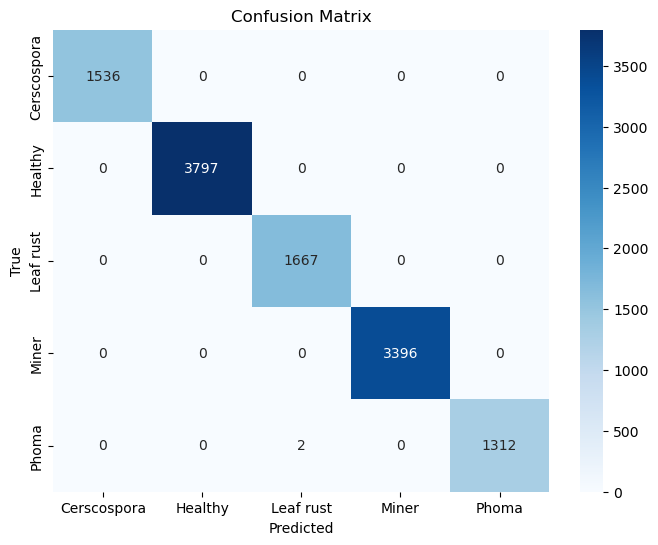

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

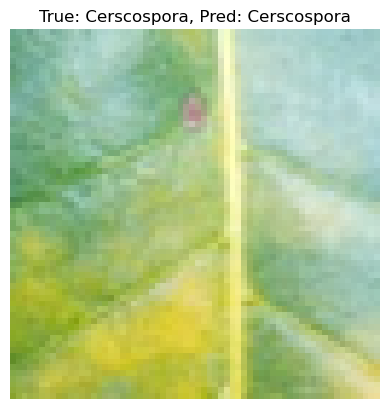

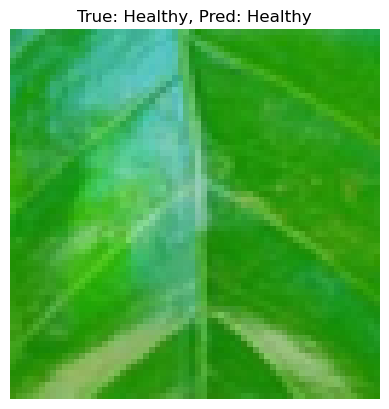

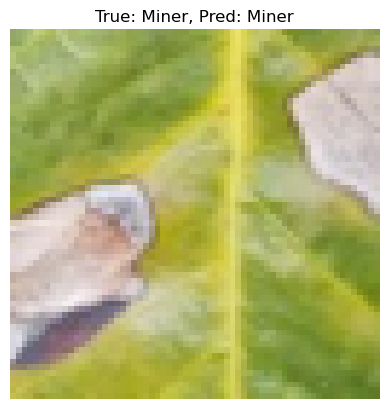

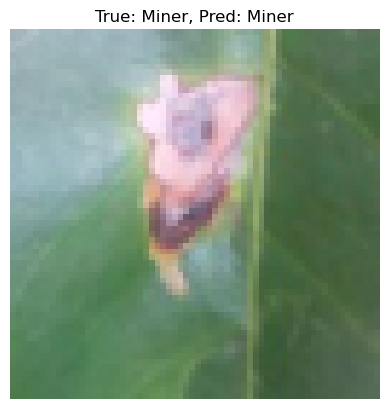

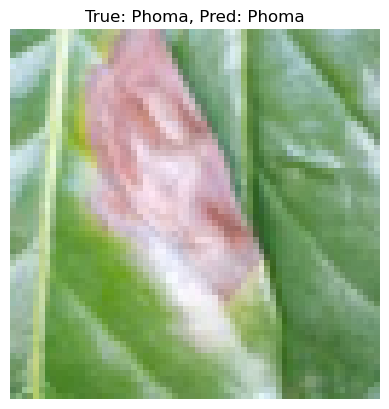

In [20]:
for i in range(5):  # Show 5 test images with predictions
    # Reshape the image back to its original shape (64, 64, 3)
    plt.imshow(X_test[i].reshape(64, 64, 3).astype('uint8'))  # Ensure uint8 type for RGB
    plt.title(f"True: {label_encoder.inverse_transform([y_test[i]])[0]}, Pred: {label_encoder.inverse_transform([y_pred[i]])[0]}")
    plt.axis('off')
    plt.show()
